In [1]:
#to do
#implement loss function for high class imbalance
import torchgeometry as tgm
import torch.utils as utils
import torchvision.transforms as TF
from PIL import Image
import numpy as np
import os
import cv2
import imageio
from pathlib import Path
import torchvision
import torch
import torch.nn as nn
from torch import optim
from torchvision import transforms
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import cv2
from tqdm.auto import tqdm

C:\Users\amin2\anaconda3\envs\Team5ARIP10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#image paths
dir_train_x = 'data/training/images/'
label_path = 'data/training/1st_manual/'
dir_test_x = 'data/test/images/'
label_test_path = 'data/test/1st_manual/'
dir_valid_x = 'data/valid/images/'
label_valid_path = 'data/valid/1st_manual/'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

images = list()
labels = list()
images_test = list()
labels_test = list()
images_valid = list()
labels_valid = list()

for file in Path(dir_train_x).iterdir():
    if not file.is_file():
        continue
    img_rgb = imageio.v2.imread(file)
    img_real = cv2.cvtColor(img_rgb, cv2.COLOR_GRAY2RGB)
    images.append(img_real)

for file in Path(label_path).iterdir():
    if not file.is_file():
        continue

    img_rgb = imageio.v2.imread(file)
    labels.append(img_rgb)
    
for file in Path(dir_test_x).iterdir():
    if not file.is_file():
        continue
    img_rgb = imageio.v2.imread(file)
    img_two = cv2.cvtColor(img_rgb, cv2.COLOR_GRAY2RGB)
    images_test.append(img_two)

for file in Path(label_test_path).iterdir():
    if not file.is_file():
        continue
    img_rgb = imageio.v2.imread(file)
    labels_test.append(img_rgb)
    
for file in Path(dir_valid_x).iterdir():
    if not file.is_file():
        continue
    img_rgb = imageio.v2.imread(file)
    img_two = cv2.cvtColor(img_rgb, cv2.COLOR_GRAY2RGB)
    images_valid.append(img_two)

for file in Path(label_valid_path).iterdir():
    if not file.is_file():
        continue
    img_rgb = imageio.v2.imread(file)
    labels_valid.append(img_rgb)

def resize(imgs,resize_height, resize_width):
    img_resize = []
    for file in imgs:
        img_resize.append(cv2.resize(file,(resize_height,resize_width)))
    return img_resize

resize_height, resize_width = (512, 512)
imgs = resize(images,resize_height, resize_width)
lbls = resize(labels,resize_height, resize_width)
imgs_test = resize(images_test,resize_height, resize_width)
lbls_test = resize(labels_test,resize_height, resize_width)
imgs_valid = resize(images_valid,resize_height, resize_width)
lbls_valid = resize(labels_valid,resize_height, resize_width)

X_train = np.array(imgs)
Y_train = np.array(lbls)
X_test = np.array(imgs_test)
Y_test = np.array(lbls_test)
X_valid = np.array(imgs_valid)
Y_valid = np.array(lbls_valid)

X_train = X_train.astype('float32')/255
Y_train = Y_train.astype('float32')/255
X_test = X_test.astype('float32')/255
Y_test = Y_test.astype('float32')/255
X_valid = X_valid.astype('float32')/255
Y_valid = Y_valid.astype('float32')/255

print("Pre-processing is finished.")
# train_data = []
# for i in range(len(X_train)):
#    train_data.append([X_train[i], Y_train[i]])

# data_loader_training = torch.utils.data.DataLoader(train_data, shuffle=False, batch_size=batchsize)

Pre-processing is finished.


In [3]:
X_train = np.transpose(X_train, (0, 3, 1, 2))
training_set = utils.data.TensorDataset(torch.Tensor(X_train), torch.Tensor(Y_train))

X_valid = np.transpose(X_valid, (0, 3, 1, 2))
valid_set = utils.data.TensorDataset(torch.Tensor(X_valid),  torch.Tensor(Y_valid))

X_test = np.transpose(X_test, (0, 3, 1, 2))
test_set = utils.data.TensorDataset(torch.Tensor(X_test),  torch.Tensor(Y_test))

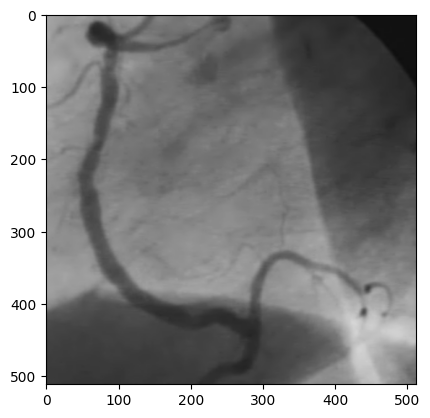

In [62]:
plt.imshow(X_test[10].transpose(1,2,0))

In [4]:
n_classes = 2
Model = smp.EfficientUnetPlusPlus(encoder_name='timm-efficientnet-b0', encoder_weights="imagenet", in_channels=3, classes=n_classes)
Model.to(device)
lr = 0.001
optimizer = optim.Adam(Model.parameters(), lr=lr)
criterion = tgm.losses.TverskyLoss(alpha=0.7, beta=0.3)
#criterion = nn.BCELoss(weight=[1,9])
# criterion = nn.CrossEntropyLoss()
batchsize = 1
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, threshold=0.001, patience = 2)

data_loader_training = torch.utils.data.DataLoader(dataset=training_set, batch_size=batchsize, shuffle=True)
data_loader_valid = torch.utils.data.DataLoader(dataset=valid_set, batch_size=batchsize, shuffle=True)
data_loader_test = torch.utils.data.DataLoader(dataset=test_set, batch_size=batchsize, shuffle=True)

In [6]:
num_epochs = 15
#one example of the validation outputs
outputs = []
for epoch in range(num_epochs):
    #perform training loop
    Model.train()
    amount=0
    loss_value = 0
    loop = tqdm(data_loader_training)
    for (img,label) in loop:
        img, label = img.to(device), label.to(device)
        decoded = Model(img)
        loss = criterion(decoded, label.type(torch.LongTensor))
        loss_value += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        amount+=1
        loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())
    loss_value = loss_value/amount

    print("Epoch", epoch, "Training loss:", loss_value, "Training dice:", )
    #perform valid loop
    Model.eval()
    loss_value = 0
    amount = 0
    loop = tqdm(data_loader_valid)
    
    with torch.no_grad():
        for (img,label) in loop:
            img, label = img.to(device), label.to(device)
            decoded = Model(img)
            loss = criterion(decoded, label.type(torch.LongTensor))
            loss_value += loss.item()
            amount +=1
            loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
            loop.set_postfix(loss=loss.item())
            
    loss_value = loss_value/amount
    scheduler.step(loss_value)    
    outputs.append((epoch, img, decoded))
    print("Epoch", epoch, "Validation loss:", loss_value, "Validation dice:", )   

Epoch [0/15]: 100%|██████████| 110/110 [08:57<00:00,  4.88s/it, loss=0.0213]


Epoch 0 Training loss: 0.02980518395250494 Training dice:


Epoch [0/15]: 100%|██████████| 11/11 [00:16<00:00,  1.54s/it, loss=0.0124]


Epoch 0 Validation loss: 0.025242160667072643 Validation dice:


Epoch [1/15]: 100%|██████████| 110/110 [09:08<00:00,  4.99s/it, loss=0.0158]


Epoch 1 Training loss: 0.026599815758791837 Training dice:


Epoch [1/15]: 100%|██████████| 11/11 [00:16<00:00,  1.54s/it, loss=0.0134]


Epoch 1 Validation loss: 0.02483691410584883 Validation dice:


Epoch [2/15]: 100%|██████████| 110/110 [09:08<00:00,  4.98s/it, loss=0.0131]


Epoch 2 Training loss: 0.025332840464331888 Training dice:


Epoch [2/15]: 100%|██████████| 11/11 [00:17<00:00,  1.62s/it, loss=0.0194]


Epoch 2 Validation loss: 0.02372309836474332 Validation dice:


Epoch [3/15]: 100%|██████████| 110/110 [09:03<00:00,  4.94s/it, loss=0.0172]


Epoch 3 Training loss: 0.024772735075517135 Training dice:


Epoch [3/15]: 100%|██████████| 11/11 [00:17<00:00,  1.61s/it, loss=0.0198]


Epoch 3 Validation loss: 0.022049985148689964 Validation dice:


Epoch [4/15]: 100%|██████████| 110/110 [09:05<00:00,  4.96s/it, loss=0.0159]


Epoch 4 Training loss: 0.023580278049815783 Training dice:


Epoch [4/15]: 100%|██████████| 11/11 [00:16<00:00,  1.53s/it, loss=0.0287]


Epoch 4 Validation loss: 0.022095788608897816 Validation dice:


Epoch [5/15]: 100%|██████████| 110/110 [09:04<00:00,  4.95s/it, loss=0.0106]


Epoch 5 Training loss: 0.022683823108673097 Training dice:


Epoch [5/15]: 100%|██████████| 11/11 [00:17<00:00,  1.56s/it, loss=0.0411]


Epoch 5 Validation loss: 0.02353790673342618 Validation dice:


Epoch [6/15]: 100%|██████████| 110/110 [08:56<00:00,  4.88s/it, loss=0.017] 


Epoch 6 Training loss: 0.02178609533743425 Training dice:


Epoch [6/15]: 100%|██████████| 11/11 [00:16<00:00,  1.49s/it, loss=0.0203]


Epoch 6 Validation loss: 0.02492212165485729 Validation dice:


Epoch [7/15]: 100%|██████████| 110/110 [09:04<00:00,  4.95s/it, loss=0.0124]


Epoch 7 Training loss: 0.020332792130383578 Training dice:


Epoch [7/15]: 100%|██████████| 11/11 [00:16<00:00,  1.54s/it, loss=0.0437]


Epoch 7 Validation loss: 0.024318229068409313 Validation dice:


Epoch [8/15]: 100%|██████████| 110/110 [09:13<00:00,  5.03s/it, loss=0.0243]


Epoch 8 Training loss: 0.019545695998451927 Training dice:


Epoch [8/15]: 100%|██████████| 11/11 [00:17<00:00,  1.61s/it, loss=0.0128]


Epoch 8 Validation loss: 0.02427230639891191 Validation dice:


Epoch [9/15]: 100%|██████████| 110/110 [09:05<00:00,  4.96s/it, loss=0.0139] 


Epoch 9 Training loss: 0.01910606243393638 Training dice:


Epoch [9/15]: 100%|██████████| 11/11 [00:15<00:00,  1.44s/it, loss=0.0208]


Epoch 9 Validation loss: 0.024743730371648617 Validation dice:


Epoch [10/15]: 100%|██████████| 110/110 [09:17<00:00,  5.06s/it, loss=0.0217] 


Epoch 10 Training loss: 0.018731128627603705 Training dice:


Epoch [10/15]: 100%|██████████| 11/11 [00:18<00:00,  1.72s/it, loss=0.0126]


Epoch 10 Validation loss: 0.023568055846474388 Validation dice:


Epoch [11/15]: 100%|██████████| 110/110 [09:24<00:00,  5.13s/it, loss=0.0126] 


Epoch 11 Training loss: 0.018589814684607766 Training dice:


Epoch [11/15]: 100%|██████████| 11/11 [00:18<00:00,  1.65s/it, loss=0.0214]


Epoch 11 Validation loss: 0.0241322246464816 Validation dice:


Epoch [12/15]: 100%|██████████| 110/110 [09:26<00:00,  5.15s/it, loss=0.0117]


Epoch 12 Training loss: 0.018490425023165617 Training dice:


Epoch [12/15]: 100%|██████████| 11/11 [00:16<00:00,  1.50s/it, loss=0.0253]


Epoch 12 Validation loss: 0.023813859982924027 Validation dice:


Epoch [13/15]: 100%|██████████| 110/110 [09:24<00:00,  5.13s/it, loss=0.0649]


Epoch 13 Training loss: 0.01852907809344205 Training dice:


Epoch [13/15]: 100%|██████████| 11/11 [00:17<00:00,  1.58s/it, loss=0.0197]


Epoch 13 Validation loss: 0.024061739444732666 Validation dice:


Epoch [14/15]: 100%|██████████| 110/110 [08:42<00:00,  4.75s/it, loss=0.0455]


Epoch 14 Training loss: 0.01846614588390697 Training dice:


Epoch [14/15]: 100%|██████████| 11/11 [00:15<00:00,  1.44s/it, loss=0.0182]

Epoch 14 Validation loss: 0.023926122622056442 Validation dice:


In [7]:
# Define the helper function
def decode_segmap(image, nc=2):
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=vessel
               (255, 255, 255)])
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
  rgb = np.stack([r, g, b], axis=2)
  return rgb

In [8]:
#show img+recon
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        axs[0, i].imshow(img)
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [63]:
Model.eval()
outputs_test = []
i= 0
with torch.no_grad():
    for (img,label) in data_loader_test:
        img, label = img.to(device), label.to(device)
        decoded = Model(img)
        loss = criterion(decoded, label.type(torch.LongTensor))
        outputs_test.append((i, img, decoded))
        print("Image", i, "Loss:", loss.item()) 
        i+=1

Image 0 Loss: 0.071072518825531
Image 1 Loss: 0.01843106746673584
Image 2 Loss: 0.030367553234100342
Image 3 Loss: 0.021250128746032715
Image 4 Loss: 0.01898103952407837
Image 5 Loss: 0.0169561505317688
Image 6 Loss: 0.02165508270263672
Image 7 Loss: 0.022178053855895996
Image 8 Loss: 0.03008139133453369
Image 9 Loss: 0.0162467360496521
Image 10 Loss: 0.023271560668945312
Image 11 Loss: 0.024355590343475342
Image 12 Loss: 0.03969597816467285


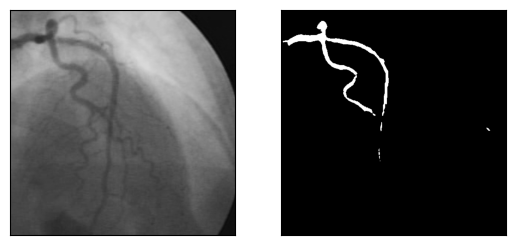

In [87]:
i = 10
orig = outputs_test[i][1].reshape(3,512,512).numpy().transpose(1,2,0)
recon = outputs_test[i][2]
preds = torch.argmax(recon.squeeze(), dim=0).detach().cpu().numpy() 
img = decode_segmap(preds)
show([orig,img])